In [2]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
import math
from datetime import date
from datetime import datetime

In [44]:
#Get WHR Stock Time Series Jan 4th 2010 - Aug 28th 2020
whr_stock = web.DataReader('WHR', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')
whr_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,82.230003,80.500000,81.379997,81.949997,1010100.0,61.762970
2010-01-05,81.949997,80.559998,81.919998,81.779999,1209300.0,61.634861
2010-01-06,82.440002,80.870003,81.730003,81.059998,1335100.0,61.092205
2010-01-07,83.489998,81.059998,81.730003,82.800003,1567300.0,62.403580
2010-01-08,84.730003,82.430000,82.430000,84.559998,1357200.0,63.730022


In [43]:
#Pull Supporting companies

##Mohawk Industries (MHK): Ships in the same trucks as WHR
mhk_stock = web.DataReader('MHK', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')
## Penske (PAG): Whirlpool Ships w/ Them
pag_stock = web.DataReader('PAG', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')
## J.B. Hunt (JBHT): Again Whirlpool Ships with them
jbht_stock = web.DataReader('JBHT', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')
## Home Depot (HD): Main Customer of Whirlpool 
hd_stock = web.DataReader('HD', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')
## Lowes (LOW): Same as HD
low_stock = web.DataReader('LOW', data_source = 'yahoo', start = '2010-01-04', end = '2020-08-21')

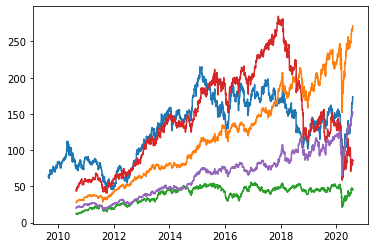

In [39]:
#Plot WHR and Other Supporting raw closing price
plt.plot(whr_stock['Close'])
plt.plot(hd_stock['Close'])
plt.plot(pag_stock['Close'])
plt.plot(mhk_stock['Close'])
plt.plot(low_stock['Close'])

In [45]:
# Find the start and end of continous time periods in data
### We treat holidays as weekends, so not all weeks are the same time length for now
weeks = []
index = 0
labels = list(whr_stock.index)
while index < (whr_stock.shape[0]) - 1:
    start_date = index
    not_found = True
    end_date = start_date
    while not_found:
        old_index = index
        if index != (whr_stock.shape[0] - 1):
            index = index + 1
            time_dif = (labels[index] - labels[old_index]).days
            if time_dif > 1:
                not_found = False
                end_date = old_index
        else: 
            end_date = index
            not_found = False
    weeks.append([start_date, end_date])

In [66]:
# Lets first define a function to consolidate our scores. 
# if the % change in a week is between +-1%, we assign it a 1. If it is <-1%, we assign a 0. If it is >1%, we assign it 2
def standardize(percent):
    if (percent > -.01) and (percent < .01):
        return 1
    elif percent > 0:
        return 2
    else:
        return 0

In [67]:
## Now we create our list of price changes
### We will create the WHR one in a seperate vector from the rest since we
### are going to "shift" the whirlpool one since we are trying to predict future price
whr_changes = []
support_changes = []
time_labels = []
for time in weeks:
    start_val_whr = whr_stock.iloc[time[0]]
    end_val_whr = whr_stock.iloc[time[1]]
    difference_whr = (start_val_whr.get('Open') - end_val_whr.get('Close') ) / start_val_whr.get('Open')
    whr_point = standardize(difference_whr)
    whr_changes.append(whr_point)
    #MHK
    start_val_mhk = mhk_stock.iloc[time[0]]
    end_val_mhk = mhk_stock.iloc[time[1]]
    difference_mhk = (start_val_mhk.get('Open') - end_val_mhk.get('Close') ) / start_val_mhk.get('Open')
    #PAG
    start_val_pag = pag_stock.iloc[time[0]]
    end_val_pag = pag_stock.iloc[time[1]]
    difference_pag = (start_val_pag.get('Open') - end_val_pag.get('Close') ) / start_val_pag.get('Open')
    #HD
    start_val_hd = hd_stock.iloc[time[0]]
    end_val_hd = hd_stock.iloc[time[1]]
    difference_hd = (start_val_hd.get('Open') - end_val_hd.get('Close') ) / start_val_hd.get('Open')
    #JBHT
    start_val_jbht = jbht_stock.iloc[time[0]]
    end_val_jbht = jbht_stock.iloc[time[1]]
    difference_jbht = (start_val_jbht.get('Open') - end_val_jbht.get('Close') )/ start_val_jbht.get('Open')
    #LOW
    start_val_low = low_stock.iloc[time[0]]
    end_val_low = low_stock.iloc[time[1]]
    difference_low = start_val_low.get('Open') - end_val_low.get('Close')
    #combine everything
    support_point = [standardize(difference_mhk), 
                     standardize(difference_pag), 
                     standardize(difference_hd),
                     standardize(difference_jbht),
                     standardize(difference_low)]
    support_changes.append(support_point)
    #Time Labels
    time_labels.append(end_val_whr.name)

In [68]:
# Now we need to combine the 2 sets. Since we are trying to predict the next week price of whirlpool,
# we will "shift" the data so that for a given date, the whr column would represent the score of next
# time period's price fluctuation. 
support_changes.pop()
time_labels.pop()
whr_changes.pop(0)
## Create DF
data = pd.DataFrame(support_changes, index = time_labels)
## Add Whirlpool
temp = pd.Series(whr_changes)
data = data.assign(e = temp.values)
## Change column Labels
data.columns = ['MHK', 'PAG', 'HD', 'JBHT', 'LOW', 'WHR']
data.head()

,MHK,PAG,HD,JBHT,LOW,WHR
2010-01-08,0,0,1,0,0,2
2010-01-15,2,2,2,1,2,2
2010-01-22,2,2,2,2,2,2
2010-01-29,2,2,1,2,2,1
2010-02-05,0,0,1,2,2,0


In [69]:
# Now we will do our analysis. We need to calculate our 9 probabilities for each stock. 
# This can be written in the notation P(x|y) where is the score of WHR and y is the score of the stock.
# We need to calculate P(0|0), P(0|1), P(0|2), P(1|0), P(1|1), P(1|2), P(2|0), P(2|1), and P(2|2) for
# each supporting stock. 

## Initialize numpy arrays to calculate P(x = y)
whr_prob = np.array([0,0,0])
mhk_prob = np.array([0,0,0])
pag_prob = np.array([0,0,0])
hd_prob = np.array([0,0,0])
jbht_prob = np.array([0,0,0])
low_prob = np.array([0,0,0])
n = data.shape[0]

# Initalize arrays to calculate P(A | B). Row is value of stock, column is val of whr
mhk_prob_relate = np.array([[0,0,0], [0,0,0], [0,0,0]])
pag_prob_relate = np.array([[0,0,0], [0,0,0], [0,0,0]])
hd_prob_relate = np.array([[0,0,0], [0,0,0], [0,0,0]])
jbht_prob_relate = np.array([[0,0,0], [0,0,0], [0,0,0]])
low_prob_relate = np.array([[0,0,0], [0,0,0], [0,0,0]])


## Count up instances of events
for index, row in data.iterrows():
    whr_prob[row['WHR']] += 1.0
    mhk_prob[row['MHK']] += 1.0
    pag_prob[row['PAG']] += 1.0
    hd_prob[row['HD']] += 1.0
    jbht_prob[row['JBHT']] += 1.0
    low_prob[row['LOW']] += 1.0
    
    mhk_prob_relate[row['MHK'], row['WHR']] += 1.0
    pag_prob_relate[row['PAG'], row['WHR']] += 1.0
    hd_prob_relate[row['HD'], row['WHR']] += 1.0
    jbht_prob_relate[row['JBHT'], row['WHR']] += 1.0
    low_prob_relate[row['LOW'], row['WHR']] += 1.0


mhk_prob_matrix = mhk_prob_relate / whr_prob[None,:]
pag_prob_matrix = pag_prob_relate / whr_prob[None,:]
jbht_prob_matrix = pag_prob_relate / whr_prob[None,:]
hd_prob_matrix = pag_prob_relate / whr_prob[None,:]
low_prob_matrix = pag_prob_relate / whr_prob[None,:]

## Divide by number of weeks to calculate probability of each stock being a state
whr_prob = whr_prob / n
mhk_prob = mhk_prob / n
pag_prob = pag_prob / n
hd_prob = hd_prob / n
jbht_prob = jbht_prob / n
low_prob = low_prob / n

## Get P(A and B)

#mhk_prob_relate = mhk_prob_relate / n
#pag_prob_relate = pag_prob_relate / n
#hd_prob_relate = hd_prob_relate / n
#jbht_prob_relate = jbht_prob_relate / n
#low_prob_relate = low_prob_relate / n


## Get P(B | A). P(B | A) = P(A and B) / P(A)
#mhk_prob_matrix = mhk_prob_relate / mhk_prob[None,:]
#pag_prob_matrix = pag_prob_relate / pag_prob[None,:]
#hd_prob_matrix = hd_prob_relate / hd_prob[None,:]
#jbht_prob_matrix = jbht_prob_relate / jbht_prob[None,:]
#low_prob_matrix = low_prob_relate / low_prob[:,None]

In [70]:
# Now we have our probabilities, we need to pull and prep our test data 

whr_test = web.DataReader('WHR', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')
##Mohawk Industries (MHK): Ships in the same trucks as WHR
mhk_test = web.DataReader('MHK', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')
## Penske (PAG): Whirlpool Ships w/ Them
pag_test = web.DataReader('PAG', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')
## J.B. Hunt (JBHT): Again Whirlpool Ships with them
jbht_test = web.DataReader('JBHT', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')
## Home Depot (HD): Main Customer of Whirlpool 
hd_test = web.DataReader('HD', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')
## Lowes (LOW): Same as HD
low_test = web.DataReader('LOW', data_source = 'yahoo', start = '2020-08-24', end = '2020-12-18')

weeks_test = []
index = 0
labels = list(whr_test.index)
while index < (whr_test.shape[0]) - 1:
    start_date = index
    not_found = True
    end_date = start_date
    while not_found:
        old_index = index
        if index != (whr_test.shape[0] - 1):
            index = index + 1
            time_dif = (labels[index] - labels[old_index]).days
            if time_dif > 1:
                not_found = False
                end_date = old_index
        else: 
            end_date = index
            not_found = False
    weeks_test.append([start_date, end_date])
#Continuing with the data prep
whr_changes_test = []
support_changes_test = []
time_labels = []
for time in weeks_test:
    start_val_whr = whr_test.iloc[time[0]]
    end_val_whr = whr_test.iloc[time[1]]
    difference_whr = (start_val_whr.get('Open') - end_val_whr.get('Close') ) / start_val_whr.get('Open')
    whr_point = standardize(difference_whr)
    whr_changes_test.append(whr_point)
    #MHK
    start_val_mhk = mhk_test.iloc[time[0]]
    end_val_mhk = mhk_test.iloc[time[1]]
    difference_mhk = (start_val_mhk.get('Open') - end_val_mhk.get('Close') ) / start_val_mhk.get('Open')
    #PAG
    start_val_pag = pag_test.iloc[time[0]]
    end_val_pag = pag_test.iloc[time[1]]
    difference_pag = (start_val_pag.get('Open') - end_val_pag.get('Close') ) / start_val_pag.get('Open')
    #HD
    start_val_hd = hd_test.iloc[time[0]]
    end_val_hd = hd_test.iloc[time[1]]
    difference_hd = (start_val_hd.get('Open') - end_val_hd.get('Close') ) / start_val_hd.get('Open')
    #JBHT
    start_val_jbht = jbht_test.iloc[time[0]]
    end_val_jbht = jbht_test.iloc[time[1]]
    difference_jbht = start_val_jbht.get('Open') - end_val_jbht.get('Close') / start_val_jbht.get('Open')
    #LOW
    start_val_low = low_test.iloc[time[0]]
    end_val_low = low_test.iloc[time[1]]
    difference_low = start_val_low.get('Open') - end_val_low.get('Close')
    #combine everything
    support_point = [standardize(difference_mhk), 
                     standardize(difference_pag), 
                     standardize(difference_hd),
                     standardize(difference_jbht),
                     standardize(difference_low)]
    support_changes_test.append(support_point)
    #Time Labels
    time_labels.append(end_val_whr.name)
support_changes_test.pop()
time_labels.pop()
whr_changes_test.pop(0)



2

In [71]:
# Now we create our predictiosn
whr_predict = []

for test_point in support_changes_test:
    maximum = -1
    prob_0 = whr_prob[0] * (mhk_prob_matrix[test_point[0], 0] *
              pag_prob_matrix[test_point[1], 0] *
              hd_prob_matrix[test_point[2], 0] *
              jbht_prob_matrix[test_point[3], 0] *
              low_prob_matrix[test_point[4], 0])
    prob_1 = whr_prob[1] * (mhk_prob_matrix[test_point[0], 1] *
              pag_prob_matrix[test_point[1], 1] *
              hd_prob_matrix[test_point[2], 1] *
              jbht_prob_matrix[test_point[3], 1] *
              low_prob_matrix[test_point[4], 1])
    prob_2 = whr_prob[2] * (mhk_prob_matrix[test_point[0], 2] *
              pag_prob_matrix[test_point[1], 2] *
              hd_prob_matrix[test_point[2], 2] *
              jbht_prob_matrix[test_point[3], 2] *
              low_prob_matrix[test_point[4], 2])
    if prob_2 > prob_1 and prob_2 > prob_0:
        maximum = 2
    elif prob_1 > prob_2 and prob_1 > prob_0:
        maximum = 1
    elif prob_0 > prob_2 and prob_0 > prob_1:
        maximum = 0
    elif prob_0 == prob_1 and prob_1 > prob_2:
        maximum = 0
    elif prob_0 == prob_2 and prob_2 > prob_1:
        maximum == 0
    elif prob_1 == prob_2 and prob_2 > prob_0:
        maximum = 2
    whr_predict.append(maximum)
# Calculate Error Rate
error_vec = pd.Series(whr_changes_test) - pd.Series(whr_predict)
print((error_vec != 0).sum()/ error_vec.count())
print(whr_prob)

0.4117647058823529
[0.41896552 0.23448276 0.34655172]
